# XGBoost Model: Base Feature Set

## This is the XGBoost model with the base feature set, i.e. not including color or storage size in the features used.

In this notebook, we'll be implementing an xgBoost model on our data.
XGBoost, which stands for Extreme Gradient Boosting, is a scalable, distributed gradient-boosted decision tree (GBDT) machine learning library. It provides parallel tree boosting and is the leading machine learning library for regression, classification, and ranking problems.

Documentation on xbgoost can be found here: https://xgboost.readthedocs.io/en/stable/tutorials/model.html

In [25]:
#load in needed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import xgboost as xgb 
from sklearn.metrics import mean_squared_error

## Load in data

The data we are loading in is the cleaned version of all of the data given by the client, including the additional data for February and March we were provided. These extra data points were added to the testing data set.

In [26]:
#%cd ../../../../data/p_dsi/teams2023/team1

In [27]:
#read in full data from xlsx file
df = pd.read_excel("full_data_clean.xlsx" )
df

,Unnamed: 0,phone model,phone size,phone color,claim,weeks_monday,brand,model,generation,week_of_month,month,year,release,weeks_since_release,is_holiday
0,3059,apple iphone 12,128gb,black,14,2021-08-02,apple,iphone,12,1,8,2021,2020-11-13,37.428571,1
1,3060,apple iphone 12,128gb,black,43,2021-08-09,apple,iphone,12,2,8,2021,2020-11-13,38.428571,1
2,3061,apple iphone 12,128gb,black,57,2021-08-16,apple,iphone,12,3,8,2021,2020-11-13,39.428571,1
3,3062,apple iphone 12,128gb,black,65,2021-08-23,apple,iphone,12,4,8,2021,2020-11-13,40.428571,1
4,3063,apple iphone 12,128gb,black,59,2021-08-30,apple,iphone,12,5,8,2021,2020-11-13,41.428571,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1273,7964,apple iphone 14 pro,128gb,silver,4,2023-02-13,apple,iphone,14,2,2,2023,2022-09-16,21.428571,0
1274,7966,apple iphone 14 pro,256gb,black,33,2023-02-27,apple,iphone,14,4,2,2023,2022-09-16,23.428571,0
1275,7968,apple iphone 14 pro,256gb,gold,2,2023-02-27,apple,iphone,14,4,2,2023,2022-09-16,23.428571,0
1276,7970,apple iphone 14 pro,256gb,purple,39,2023-02-27,apple,iphone,14,4,2,2023,2022-09-16,23.428571,0


In [28]:
#load in data for testing and training the model 
train = pd.read_excel("train_data_final.xlsx" )
test = pd.read_excel("test_data_final.xlsx" )

### Feature engineering 

First, we'll drop features we don't need in our data.

In [29]:
#drop phone model (we know the phone model based on the generation of the phone)
train = train.drop(['phone model'], axis=1)

test = test.drop(['phone model'], axis=1)

In [30]:
#drop is_holiday
train = train.drop(['is_holiday'], axis=1)
test = test.drop(['is_holiday'], axis=1)

In [31]:
#drop unamed: 0 from train data (this is the index column)
train = train.drop(['Unnamed: 0'], axis=1)
test = test.drop(['Unnamed: 0'], axis=1)

In [32]:
#drop phone size (not included in this feature set)
train = train.drop(['phone size'], axis=1)
test = test.drop(['phone size'], axis=1)

In [33]:
#drop phone color (not included in this feature set)
test = test.drop(['phone color'], axis=1)
train = train.drop(['phone color'], axis=1)

In [34]:
#examine the data to make sure it is correct
train.head(10)

,claim,weeks_monday,generation,week_of_month,month,year,weeks_since_release,day
0,14,2021-08-02,12,1,8,2021,37.428571,2
1,43,2021-08-09,12,2,8,2021,38.428571,9
2,57,2021-08-16,12,3,8,2021,39.428571,16
3,65,2021-08-23,12,4,8,2021,40.428571,23
4,59,2021-08-30,12,5,8,2021,41.428571,30
5,45,2021-09-06,12,1,9,2021,42.428571,6
6,49,2021-09-13,12,2,9,2021,43.428571,13
7,54,2021-09-20,12,3,9,2021,44.428571,20
8,62,2021-09-27,12,4,9,2021,45.428571,27
9,65,2021-10-04,12,1,10,2021,46.428571,4


## Examine phone trends before modeling

Plot a time series graph for the iPhone 12, 13, and 14 based on their release and generation

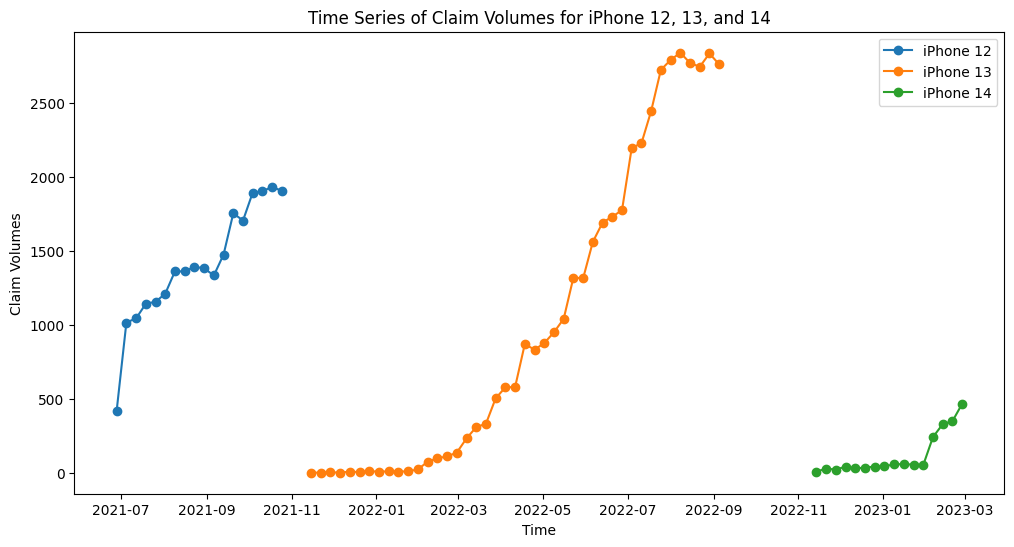

In [35]:
# Filter data for iPhones 12, 13, and 14
selected_iphones = df[df['generation'].isin([12, 13, 14])]
selected_iphones = selected_iphones[['claim', 'weeks_since_release', 'weeks_monday', 'generation']]

# Group by weeks_monday and generation, sum up all the claims
grouped_data = selected_iphones.groupby(['weeks_monday', 'generation']).agg({'claim': 'sum'}).reset_index()

# Pivot the table to have generations as columns
pivot_data = grouped_data.pivot_table(index='weeks_monday', columns='generation', values='claim', fill_value=0).reset_index()


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for gen in [12, 13, 14]:
    # Filter out rows with zero claims
    filtered_data = pivot_data[pivot_data[gen] > 0]
    
    plt.plot(filtered_data['weeks_monday'], filtered_data[gen], label=f"iPhone {gen}", marker='o')

plt.xlabel("Time")
plt.ylabel("Claim Volumes")
plt.title("Time Series of Claim Volumes for iPhone 12, 13, and 14")
plt.legend()
plt.show()

## Model Creation

### Create training and testing set

In [36]:
#for dataset that has time series, set the datetime value as the index variable
# set week_of_month as index

#set the index of the training data to be the weeks_monday
train = train.set_index("weeks_monday")
train.head()

,claim,generation,week_of_month,month,year,weeks_since_release,day
weeks_monday,,,,,,,
2021-08-02,14,12,1,8,2021,37.428571,2
2021-08-09,43,12,2,8,2021,38.428571,9
2021-08-16,57,12,3,8,2021,39.428571,16
2021-08-23,65,12,4,8,2021,40.428571,23
2021-08-30,59,12,5,8,2021,41.428571,30


In [37]:
#set the index of the testing data to be the weeks_monday
test = test.set_index("weeks_monday")

#drop index column from testing data
#test = test.drop(['index'], axis=1)

In [38]:
test.head(15)

,claim,generation,week_of_month,month,year,weeks_since_release,day
weeks_monday,,,,,,,
2022-12-19,20,14,3,12,2022,13.428571,19
2022-12-26,23,14,4,12,2022,14.428571,26
2023-01-02,28,14,1,1,2023,15.428571,2
2023-01-09,37,14,2,1,2023,16.428571,9
2023-01-16,35,14,3,1,2023,17.428571,16
2023-01-23,39,14,4,1,2023,18.428571,23
2023-01-30,33,14,5,1,2023,19.428571,30
2022-12-19,8,14,3,12,2022,13.428571,19
2022-12-26,5,14,4,12,2022,14.428571,26


#### Set x,y train and test

In [39]:
#set x,y train and test

x_train = train.drop('claim', axis=1)
y_train = train['claim']

x_test = test.drop('claim', axis=1)
y_test = test['claim']

x_train.shape, y_train.shape

((1205, 6), (1205,))

### Fit the Model

In [40]:
model = xgb.XGBRegressor(base_score =0.2, booster='gbtree', n_estimators =1000,
                        objective = 'reg:linear', max_depth =5, learning_rate=0.01)

model.fit(x_train, y_train, 
           eval_set = [(x_train, y_train), (x_test, y_test)] ) 


[21:50:45] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:84.81289	validation_1-rmse:38.38306
[1]	validation_0-rmse:84.40637	validation_1-rmse:38.24839
[2]	validation_0-rmse:84.00598	validation_1-rmse:38.11549
[3]	validation_0-rmse:83.61164	validation_1-rmse:37.98434
[4]	validation_0-rmse:83.22329	validation_1-rmse:37.85490
[5]	validation_0-rmse:82.84085	validation_1-rmse:37.72716
[6]	validation_0-rmse:82.46425	validation_1-rmse:37.60111
[7]	validation_0-rmse:82.09342	validation_1-rmse:37.47671
[8]	validation_0-rmse:81.72828	validation_1-rmse:37.35396
[9]	validation_0-rmse:81.36878	validation_1-rmse:37.23282
[10]	validation_0-rmse:81.01483	validation_1-rmse:37.11329
[11]	validation_0-rmse:80.66638	validation_1-rmse:36.99545
[12]	validation_0-rmse:80.32334	validation_1-rmse:36.87918
[13]	validat

XGBRegressor(base_score=0.2, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

## Model Evaluation

In [41]:
x_test.shape, y_test.shape

((73, 6), (73,))

#### Mean Squared Error

In [42]:
#finding the rmse score for the model

y_pred = model.predict(x_test)
score = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE Score on test set: {score:0.2f}')

RMSE Score on test set: 28.16


#### WMAPE

In [43]:
# Reference: https://www.indeed.com/career-advice/career-development/weighted-mean-absolute-percentage-error

def wmape(actual, forecast):
    """Calculate Weighted Mean Absolute Percentage Error (WMAPE) with equal weights"""

    weights = np.abs(actual - forecast)
    numerator = np.sum(weights) * 100
    denominator = np.sum(np.abs(actual))

    return numerator/denominator

In [44]:
#using wmape value on our data
wmape_value = wmape(y_test, y_pred)
print("WMAPE: {:.2f}%".format(wmape_value))

WMAPE: 82.36%


This WMAPE is very high, so this model may not be the best choice for prediction.

### Plot Model Performance

In [50]:
#define the variable y_train_fit
y_train_fit = model.predict(x_train)

In [51]:
# add the y_train and y_pred to x_train as 2 new columns 
x_test['pred'] = y_pred
x_test['claim'] = y_test
x_train['pred'] = y_train_fit
x_train['claim'] = y_train

plot_df = pd.concat([x_train, x_test])

plot_df

,generation,week_of_month,month,year,weeks_since_release,day,pred,claim
weeks_monday,,,,,,,,
2021-08-02,12,1,8,2021,37.428571,2,57.756828,14
2021-08-09,12,2,8,2021,38.428571,9,59.186897,43
2021-08-16,12,3,8,2021,39.428571,16,56.814068,57
2021-08-23,12,4,8,2021,40.428571,23,58.068172,65
2021-08-30,12,5,8,2021,41.428571,30,55.333931,59
...,...,...,...,...,...,...,...,...
2023-02-13,14,2,2,2023,21.428571,13,25.816866,4
2023-02-27,14,4,2,2023,23.428571,27,27.587856,33
2023-02-27,14,4,2,2023,23.428571,27,27.587856,2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

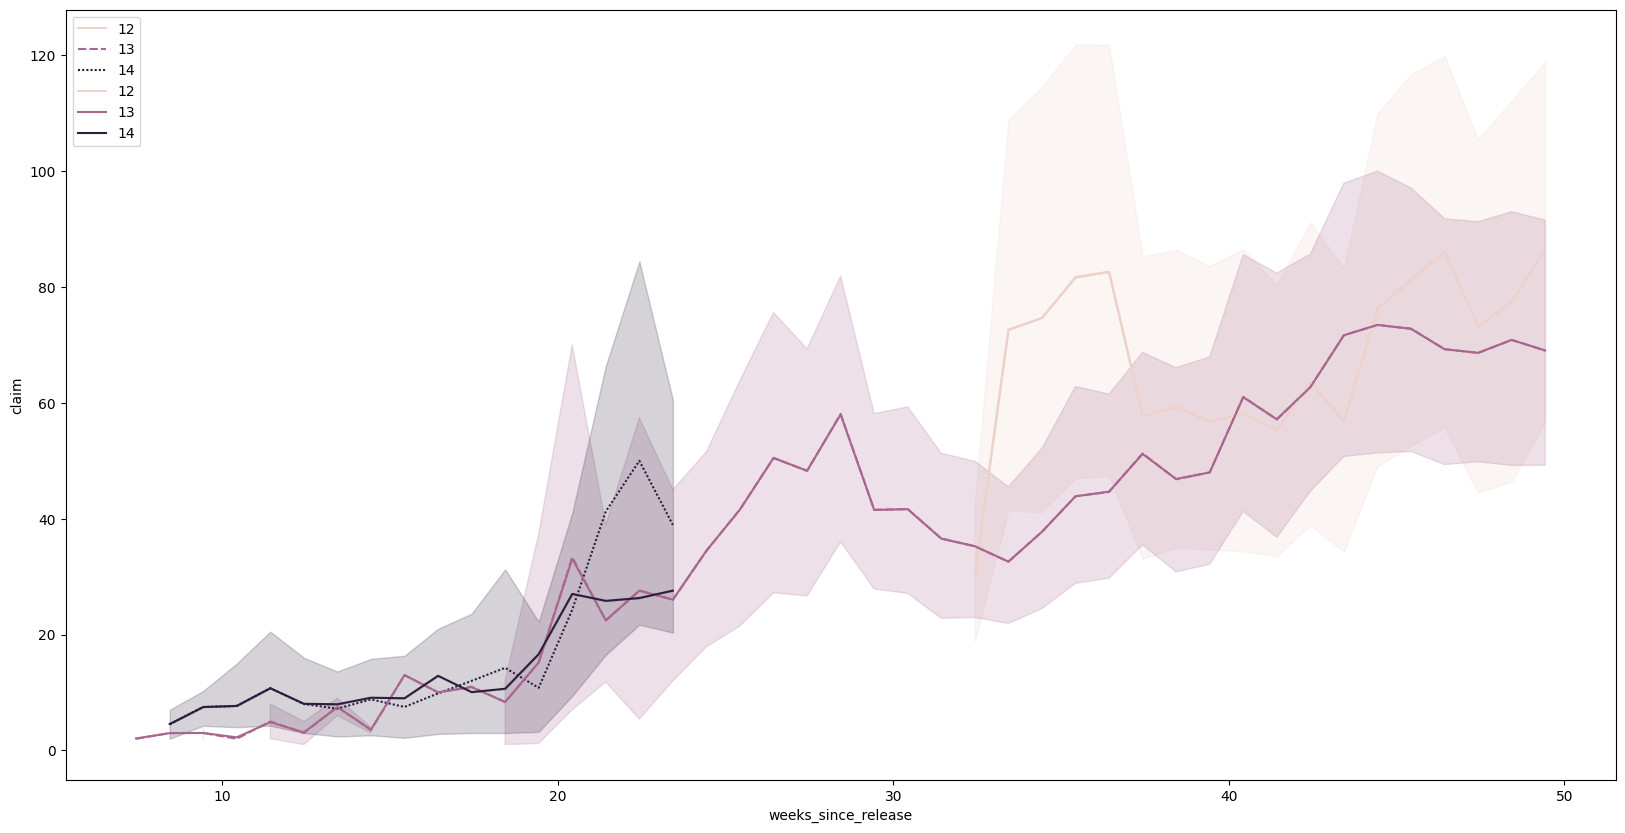

In [52]:
# plot the xgboost results for both the actual and predicted values, x-axis is the weeks_monday and y-axis is the claim and group_by each phone model. 
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(x="weeks_since_release", y="claim", hue="generation", data=plot_df, ax=ax, style= "generation")
sns.lineplot(x="weeks_since_release", y="pred", hue="generation", data=plot_df, ax=ax, markers=True, dashes=True)
plt.legend(loc='upper left')
# add another legend to show that the dashes line is the actual value and the line is the predicted value
plt.show()

Now plot with grouping the phone generations together.

In [53]:
# group by the pred and claim by phone size, generation, week_of_month, month, year, weeks_since_release, do not aggregate the pred and claim columns
new_df = plot_df.groupby(['generation', 'week_of_month', 'month', 'year', 'weeks_since_release'])['pred', 'claim'].sum()
new_df = new_df.reset_index()
new_df

C:\Users\Rachel Montgomery\AppData\Local\Temp\ipykernel_19492\1420137929.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  new_df = plot_df.groupby(['generation', 'week_of_month', 'month', 'year', 'weeks_since_release'])['pred', 'claim'].sum()


,generation,week_of_month,month,year,weeks_since_release,pred,claim
0,12,1,7,2021,33.428571,1016.448242,1017
1,12,1,8,2021,37.428571,1212.893433,1212
2,12,1,9,2021,42.428571,1334.137695,1335
3,12,1,10,2021,46.428571,1894.179932,1895
4,12,2,7,2021,34.428571,1045.252930,1045
...,...,...,...,...,...,...,...
72,14,4,1,2023,18.428571,42.564529,57
73,14,4,2,2023,23.428571,331.054260,467
74,14,4,11,2022,10.428571,23.031244,23
75,14,4,12,2022,14.428571,45.458675,44


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

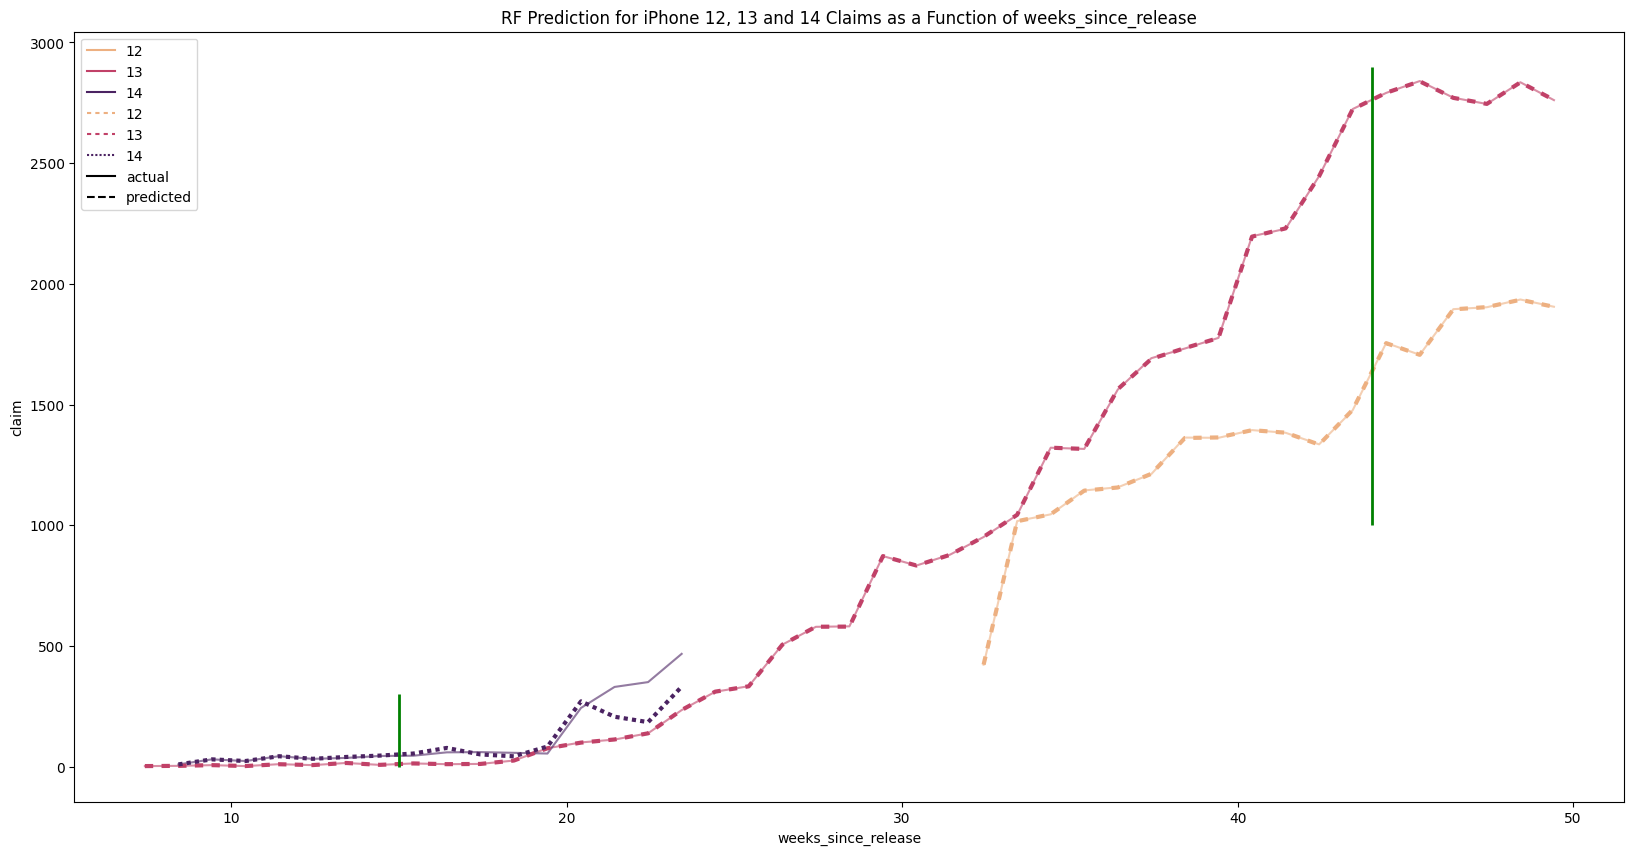

In [54]:
# plot the xgboost results for both the actual and predicted values, x-axis is the weeks_since_release and y-axis is the claim and pred for each phone model
# the line is the actual value and the dashes line is the  predicted value 
# use the same dashed style for all the generations
palette = sns.color_palette("flare", as_cmap=True)

fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(x="weeks_since_release", y="claim", hue="generation", data=new_df, palette=palette, ax=ax, alpha=0.6)
sns.lineplot(x="weeks_since_release", y="pred", hue="generation", data=new_df, palette=palette, ax=ax, style= "generation", dashes=[(2, 2), (2, 2), (1, 1)], linewidth = 3)

# add another legend to show that the dashed line is the actual value and the solid line is the predicted value
ax.plot([],[], label='actual', color = 'black')
ax.plot([],[], linestyle='--', label='predicted', color = 'black')
# add a title to the plot
ax.set_title('RF Prediction for iPhone 12, 13 and 14 Claims as a Function of weeks_since_release')
# add a verticle line at x = 44 with a hight of 80
plt.vlines(x=44, ymin=1000, ymax=2900, color='green', linewidth=2)
plt.vlines(x=15, ymin=0, ymax=300, color='green', linewidth=2)

plt.legend(loc='upper left')
plt.show()

### Feature Importance 

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

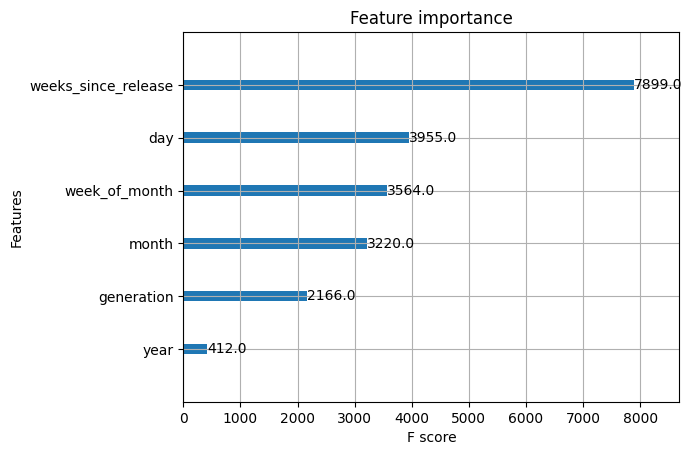

In [45]:
#do feature importance
xgb.plot_importance(model)